#SPH5104 Group Assignment: Team 4

group members:

Ong Yan Chun       

Zhuang Wen Xi        

Shalini D/O Ponnalagu          

Yew Kwang Sing	     

Zhuang Wen Xi 

In [53]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logit, expit
random.seed()

# Widen width of notebook and increase dataframe dimensions
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline

if not sys.warnoptions:
    import warnings
    #suppress warning messages (those with peach background)
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore', category=FutureWarning)

In [54]:
pip install researchpy

In [55]:
data_file = 'before_matching_data_final.csv'
# Outcome Columns
col_mortality90 = 'mortality_90day'
col_mortality30 = 'mortality_30day'
col_mortality_hos = 'mortality_hos'
col_ventfree = 'vent_free_days'
# Treatment Column
col_cisatracurium = 'groups'
# Numerical Columns
col_hospital_los = 'los_hospital'
col_icu_los = 'los_icu'
col_age = 'age'
col_weight = 'weight'
col_saps = 'sapsii'
col_sofa = 'sofa'
col_pf = 'hours48before_pao2fio2'  
# Categorical Columns
col_gender = 'gender'
col_unit = 'first_careunit'
col_prone = 'prone'
# Categorical Dummy Columns
col_genderM = 'gender_M'
col_genderF = 'gender_F'
col_unitCSRU = 'first_careunit_CSRU'
col_unitMICU = 'first_careunit_MICU'
col_unitSICU = 'first_careunit_SICU'
col_unitTSICU = 'first_careunit_TSICU'	
# Column Lists
feature_columns = [col_hospital_los, col_icu_los, col_age, col_weight, col_saps, col_sofa, col_pf, col_gender, col_unit, col_prone]
categorical_columns = [col_gender, col_unit, col_prone]
numerical_columns = [col_hospital_los, col_icu_los, col_age, col_weight, col_saps, col_sofa, col_pf]
outcome_columns = [col_mortality90, col_mortality30, col_mortality_hos, col_ventfree]
mortality_columns = [col_mortality90, col_mortality30, col_mortality_hos]
treated_columns = [col_cisatracurium]
# Type Definitions
cat_type = 'category'
# Set path
path = '/D/My Drive/Colab Notebooks/SPH5104/Code/Dataset/'+ data_file

In [56]:
# Read  Dataset
df_raw = pd.read_csv(path, na_values=["nan","null"])

Drive already mounted at /D; to attempt to forcibly remount, call drive.mount("/D", force_remount=True).


# 2. Data Exploration & Preprocessing


In [57]:
df_raw.rename(columns={'admission_age.edited': 'age', 'hours48before.pao2fio2': 'hours48before_pao2fio2', 'hours48before.spo2': 'spo2', 'prone.position.relabelled': 'prone', 'TREAT1ELSE0': 'groups'}, inplace=True)

In [58]:
columns_to_keep = feature_columns + outcome_columns + treated_columns
df_data = df_raw[columns_to_keep]

#replace all missing values with NaN
df_data = df_data.replace(np.nan, np.NaN, regex=True)

print('Dataset contains', df_data.shape[0], 'rows and', df_data.shape[1], 'coloumns:')
df_data.head(15)

Dataset contains 1110 rows and 15 coloumns:


,los_hospital,los_icu,age,weight,sapsii,sofa,hours48before_pao2fio2,gender,first_careunit,prone,mortality_90day,mortality_30day,mortality_hos,vent_free_days,groups
0,10.074,4.348,72.733,106.200,31,5,140.000,M,MICU,0,0,0,0,25.312,0
1,27.219,3.394,56.643,75.000,21,3,78.000,M,SICU,0,0,0,0,26.896,0
2,28.954,20.029,38.497,103.500,17,4,247.500,M,TSICU,0,0,0,0,11.486,0
3,15.778,9.892,82.186,65.400,54,7,193.333,M,MICU,0,1,1,1,18.986,0
4,13.935,5.133,74.719,121.400,37,6,134.286,M,CSRU,0,0,0,0,27.250,0
5,27.226,27.138,63.137,102.200,40,14,172.000,M,CSRU,0,0,0,0,16.128,0
6,18.775,12.856,71.859,85.000,61,8,222.500,F,SICU,0,0,0,0,26.875,0
7,18.376,12.305,91.400,82.000,63,6,180.000,M,TSICU,0,0,0,0,19.750,1
8,19.241,11.492,33.042,65.900,37,5,123.000,M,TSICU,0,0,0,0,18.973,0
9,28.689,28.688,45.356,87.000,39,7,250.000,M,TSICU,0,0,0,0,0.208,0


In [59]:
# check the extent of missing data for each col
cn = list(df_data)
missing_count = []
proportion = []

for var in cn:
    m_count = df_data[var].isna().sum()
    extent = round((m_count/(df_data.shape[0]))*100,2)
    missing_count.append(m_count)
    proportion.append(extent)

tab_missing_count = pd.DataFrame({'variable': cn, 'missing_count': missing_count, 'proportion_%':proportion})
print(tab_missing_count)

                  variable  missing_count  proportion_%
0             los_hospital              0         0.000
1                  los_icu              0         0.000
2                      age              0         0.000
3                   weight              0         0.000
4                   sapsii              0         0.000
5                     sofa              0         0.000
6   hours48before_pao2fio2              0         0.000
7                   gender              0         0.000
8           first_careunit              0         0.000
9                    prone              0         0.000
10         mortality_90day              0         0.000
11         mortality_30day              0         0.000
12           mortality_hos              0         0.000
13          vent_free_days              0         0.000
14                  groups              0         0.000


IndexError: ignored

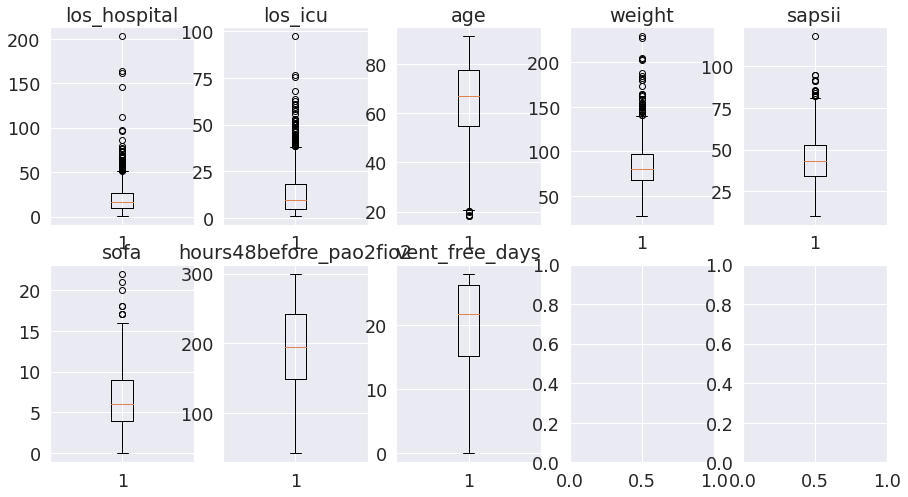

In [60]:
# numeric variables
num_xvar = numerical_columns + [col_ventfree]

# specify function to call out variable to plot
def var(row, column):
    if row ==0:
        return num_xvar[column]
    else:
        return num_xvar[column+5]

# function to plot boxplot for each variable
def boxplots(data):
    
    data.dropna()

    # define plot grid
    fig, axs = plt.subplots(2,5, figsize=(15,8))
    
    # loop to plot each numeric variable
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].boxplot(data[var(i,j)].dropna())
            axs[i, j].set_title(var(i,j))
    
    return plt.show()

boxplots(df_data)

In [61]:
cat_cols = df_data.columns[df_data.dtypes==object]
df_data[cat_cols] = df_data[cat_cols].fillna('MISSING')

In [62]:
# categorical variables
cat_var = categorical_columns + mortality_columns + treated_columns 

for var in cat_var:
    values = set(df_data[var])
    uq = len(values)
    print('\nNumber of unique values for '+ var +' is:', str(uq) + '.')
    print('The unique values are:', values)


Number of unique values for gender is: 2.
The unique values are: {'M', 'F'}

Number of unique values for first_careunit is: 5.
The unique values are: {'CSRU', 'CCU', 'MICU', 'TSICU', 'SICU'}

Number of unique values for prone is: 2.
The unique values are: {0, 1}

Number of unique values for mortality_90day is: 2.
The unique values are: {0, 1}

Number of unique values for mortality_30day is: 2.
The unique values are: {0, 1}

Number of unique values for mortality_hos is: 2.
The unique values are: {0, 1}

Number of unique values for groups is: 2.
The unique values are: {0, 1}


In [63]:
x = numerical_columns + treated_columns

data_norm = df_data[x].copy()
scaler = MinMaxScaler()

data_norm [x] = scaler.fit_transform(data_norm[x])
data_norm.head()  

,los_hospital,los_icu,age,weight,sapsii,sofa,hours48before_pao2fio2,groups
0,0.047,0.035,0.745,0.391,0.194,0.227,0.380,0.000
1,0.132,0.025,0.526,0.236,0.102,0.136,0.140,0.000
2,0.141,0.197,0.278,0.378,0.065,0.182,0.797,0.000
3,0.075,0.092,0.874,0.189,0.407,0.318,0.587,0.000
4,0.066,0.043,0.772,0.467,0.250,0.273,0.358,0.000


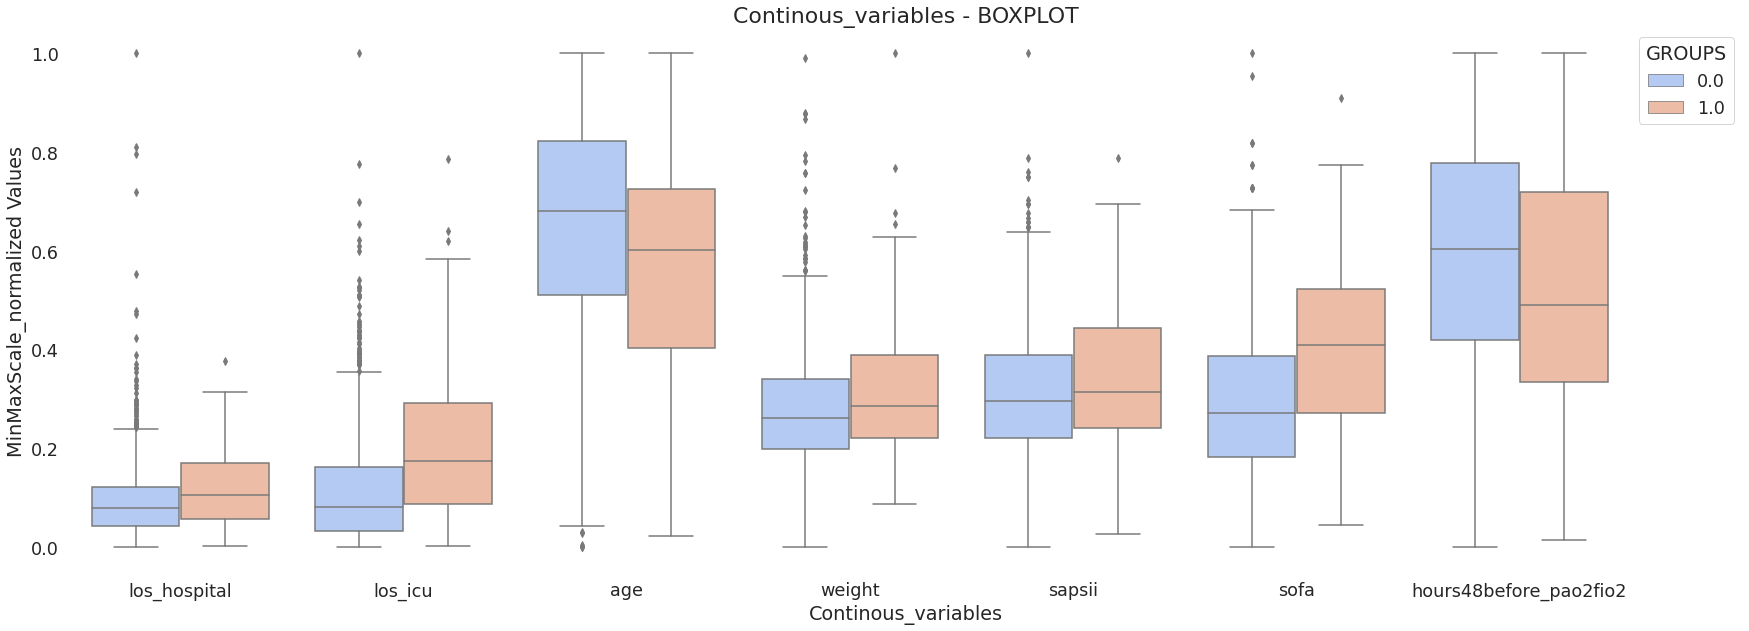

In [64]:
df_1 = pd.melt(data_norm,id_vars="groups",
                    var_name="Continous_variables",
                    value_name='MinMaxScale_normalized Values')

plt.figure(figsize=(30,10))
sns.set_context('notebook', font_scale=1.6)
sns.boxplot(y="MinMaxScale_normalized Values", x="Continous_variables", hue="groups", data=df_1, palette='coolwarm')
#plt.ylim(-5,5)
plt.legend(loc='best', title= 'GROUPS', facecolor='white')

plt.xlim([-0.5,7])
plt.title('Continous_variables - BOXPLOT', size=22)
plt.box(False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


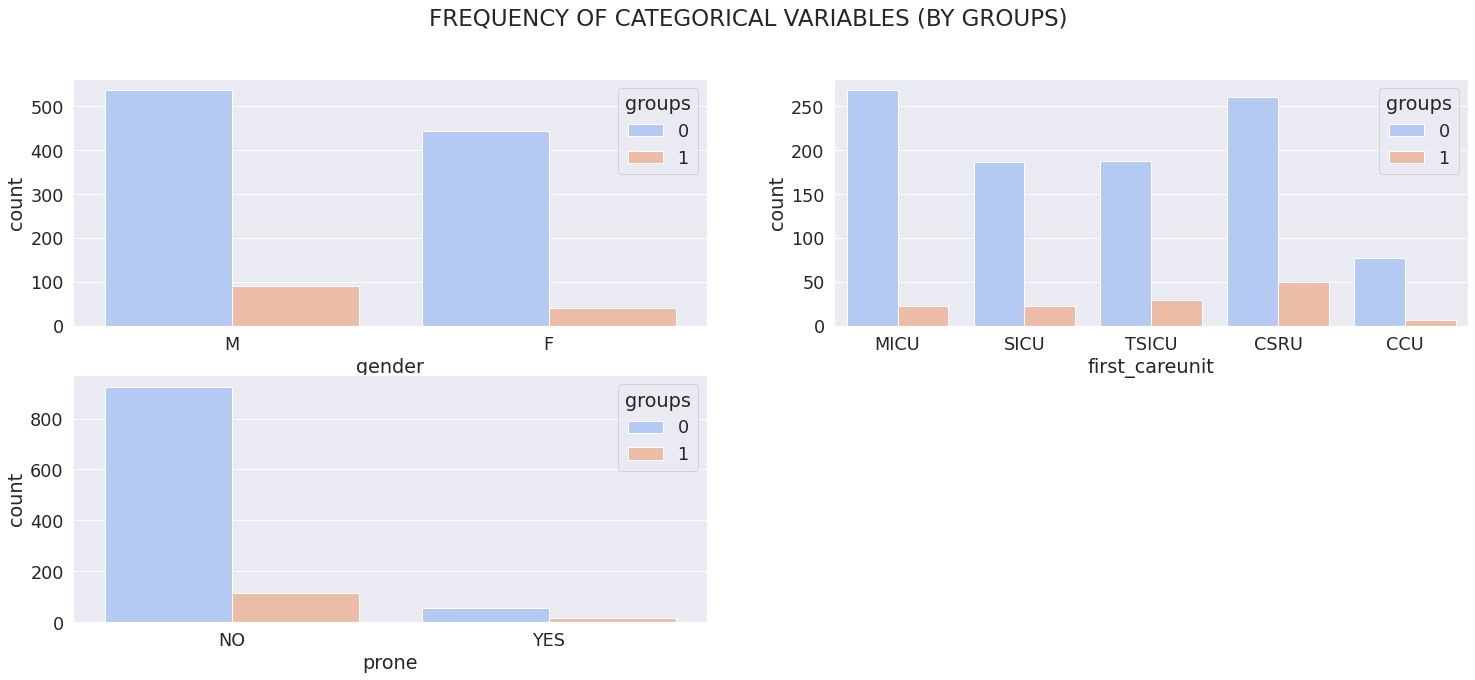

In [65]:
#recode
subset = df_data[categorical_columns+treated_columns]
subset[col_prone] = subset[col_prone].replace({0: 'NO', 1: 'YES'})

#plot demographic categorical variables against outcome
f, axes = plt.subplots(2,2,figsize=(25, 10), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY GROUPS)')

ax1 = sns.countplot(x=col_gender, hue="groups", data=subset, palette="coolwarm", ax=axes[0,0])
ax2 = sns.countplot(x=col_unit, hue="groups", data=subset, palette="coolwarm",ax=axes[0,1])
ax3 = sns.countplot(x=col_prone, hue="groups", data=subset, palette="coolwarm",ax=axes[1,0])

f.delaxes(ax=axes[1,1])


## 3. Feature Engineering

In [66]:
df_data = pd.get_dummies(data=df_data, columns= [col_unit,col_gender], drop_first=False)
df_data.head (15)

,los_hospital,los_icu,age,weight,sapsii,sofa,hours48before_pao2fio2,prone,mortality_90day,mortality_30day,mortality_hos,vent_free_days,groups,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,gender_F,gender_M
0,10.074,4.348,72.733,106.200,31,5,140.000,0,0,0,0,25.312,0,0,0,1,0,0,0,1
1,27.219,3.394,56.643,75.000,21,3,78.000,0,0,0,0,26.896,0,0,0,0,1,0,0,1
2,28.954,20.029,38.497,103.500,17,4,247.500,0,0,0,0,11.486,0,0,0,0,0,1,0,1
3,15.778,9.892,82.186,65.400,54,7,193.333,0,1,1,1,18.986,0,0,0,1,0,0,0,1
4,13.935,5.133,74.719,121.400,37,6,134.286,0,0,0,0,27.250,0,0,1,0,0,0,0,1
5,27.226,27.138,63.137,102.200,40,14,172.000,0,0,0,0,16.128,0,0,1,0,0,0,0,1
6,18.775,12.856,71.859,85.000,61,8,222.500,0,0,0,0,26.875,0,0,0,0,1,0,1,0
7,18.376,12.305,91.400,82.000,63,6,180.000,0,0,0,0,19.750,1,0,0,0,0,1,0,1
8,19.241,11.492,33.042,65.900,37,5,123.000,0,0,0,0,18.973,0,0,0,0,0,1,0,1
9,28.689,28.688,45.356,87.000,39,7,250.000,0,0,0,0,0.208,0,0,0,0,0,1,0,1


##5) Propensity Score Matching


In [67]:
# treatment will be our label for estimating the propensity score,
# and death is the outcome that we care about, thus is also removed
# from the step that is estimating the propensity score

treatment = df_data[col_cisatracurium]
num_cols = numerical_columns 
df_data2 = df_data.copy()

treatment = df_data2[col_cisatracurium]
mortality_90day = df_data2[col_mortality90]
df_data2.drop(columns=[col_mortality90,col_cisatracurium],inplace=True, axis=1)
column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_data2)
data.shape

(1110, 18)

In [68]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.01625347, 0.03694384, 0.18405434, ..., 0.01756793, 0.02183564,
       0.01652972])

In [70]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]

In [71]:
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.head(2)

,los_hospital,los_icu,age,weight,sapsii,sofa,hours48before_pao2fio2,prone,mortality_90day,mortality_30day,mortality_hos,vent_free_days,groups,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,gender_F,gender_M,propensity_score_logit
0,10.074,4.348,72.733,106.200,31,5,140.000,0,0,0,0,25.312,0,0,0,1,0,0,0,1,-4.103
1,27.219,3.394,56.643,75.000,21,3,78.000,0,0,0,0,26.896,0,0,0,0,1,0,0,1,-3.261


In [72]:
features = df_data.columns.tolist()
features.remove('groups')
features.remove('mortality_90day')
agg_operations = {'groups': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})
table_one = df_data.groupby('groups').agg(agg_operations) 

print('Dataset contains', table_one.shape[0], 'rows and', table_one.shape[1], 'coloumns:')
table_one.head()

Dataset contains 2 rows and 39 coloumns:


groups los_hospital        los_icu           age        weight         \
        count         mean    std    mean    std   mean    std   mean    std   
groups                                                                         
0         979       20.309 17.081  12.446 11.449 65.763 15.940 83.961 24.409   
1         131       25.359 15.955  20.784 15.148 59.054 16.693 91.231 28.053   

       sapsii         sofa       hours48before_pao2fio2        prone        \
         mean    std  mean   std                   mean    std  mean   std   
groups                                                                       
0      43.771 13.882 6.598 3.329                194.537 59.916 0.056 0.230   
1      47.206 16.207 8.870 3.730                176.008 64.673 0.122 0.329   

       mortality_30day       mortality_hos       vent_free_days        \
                  mean   std          mean   std           mean   std   
groups                                                                  
0                0.187 0.390         0.200 0.400         20.116 7.866   
1                0.305 0.462         0.321 0.469         13.587 9.330   

       first_careunit_CCU       first_careunit_CSRU       first_careunit_MICU  \
                     mean   std                mean   std                mean   
groups                                                                          
0                   0.079 0.269               0.266 0.442               0.274   
1                   0.053 0.226               0.382 0.488               0.176   

             first_careunit_SICU       first_careunit_TSICU       gender_F  \
         std                mean   std                 mean   std     mean   
groups                                                                       
0      0.446               0.190 0.392                0.192 0.394    0.453   
1      0.382               0.168 0.375                0.221 0.417    0.305   

             gender_M       propensity_score_logit        
         std     mean   std                   mean   std  
groups                                                    
0      0.498    0.547 0.498                 -2.745 1.199  
1      0.462    0.695 0.462                 -1.231 1.176

In [73]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})

table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,los_hospital,0.306
1,los_icu,0.621
2,age,0.411
3,weight,0.277
4,sapsii,0.228
5,sofa,0.643
6,hours48before_pao2fio2,0.297
7,prone,0.232
8,mortality_30day,0.277
9,mortality_hos,0.276


In [74]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices

sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)

In [75]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([ 0, 88,  9,  3,  1,  0,  2])

In [76]:
df_data['groups'] = treatment
df_data['mortality_90day'] = mortality_90day
df_pos = df_data[mask]
df_neg = df_data[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)

print('Dataset contains', df_matched.shape[0], 'rows and', df_matched.shape[1], 'coloumns:')
df_matched.head()

Dataset contains 262 rows and 21 coloumns:


,los_hospital,los_icu,age,weight,sapsii,sofa,hours48before_pao2fio2,prone,mortality_90day,mortality_30day,mortality_hos,vent_free_days,groups,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,gender_F,gender_M,propensity_score_logit
7,18.376,12.305,91.400,82.000,63,6,180.000,0,0,0,0,19.750,1,0,0,0,0,1,0,1,-3.482
19,7.263,7.357,63.280,80.000,44,11,153.750,0,1,1,1,20.833,1,0,0,0,0,1,0,1,-1.050
21,9.886,9.975,72.480,72.600,56,10,256.000,0,1,1,1,20.812,1,1,0,0,0,0,1,0,-2.471
24,47.764,44.263,71.622,70.300,48,3,207.500,0,0,0,0,0.000,1,0,1,0,0,0,0,1,-1.128
41,11.451,7.738,74.782,83.600,51,6,145.000,0,1,1,1,20.625,1,0,1,0,0,0,1,0,-1.781


In [77]:
features = df_matched.columns.tolist()
features.remove('groups')
features.remove('mortality_90day')
agg_operations = {'groups': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})
table_two = df_matched.groupby('groups').agg(agg_operations) 

table_two.head()

groups los_hospital        los_icu           age        weight         \
        count         mean    std    mean    std   mean    std   mean    std   
groups                                                                         
0         131       25.817 17.423  20.598 15.947 60.169 16.464 92.513 27.248   
1         131       25.359 15.955  20.784 15.148 59.054 16.693 91.231 28.053   

       sapsii         sofa       hours48before_pao2fio2        prone        \
         mean    std  mean   std                   mean    std  mean   std   
groups                                                                       
0      49.992 17.479 9.130 3.931                168.655 62.130 0.115 0.320   
1      47.206 16.207 8.870 3.730                176.008 64.673 0.122 0.329   

       mortality_30day       mortality_hos       vent_free_days        \
                  mean   std          mean   std           mean   std   
groups                                                                  
0                0.313 0.465         0.313 0.465         13.553 8.875   
1                0.305 0.462         0.321 0.469         13.587 9.330   

       first_careunit_CCU       first_careunit_CSRU       first_careunit_MICU  \
                     mean   std                mean   std                mean   
groups                                                                          
0                   0.046 0.210               0.344 0.477               0.229   
1                   0.053 0.226               0.382 0.488               0.176   

             first_careunit_SICU       first_careunit_TSICU       gender_F  \
         std                mean   std                 mean   std     mean   
groups                                                                       
0      0.422               0.198 0.400                0.183 0.388    0.260   
1      0.382               0.168 0.375                0.221 0.417    0.305   

             gender_M       propensity_score_logit        
         std     mean   std                   mean   std  
groups                                                    
0      0.440    0.740 0.440                 -1.248 1.142  
1      0.462    0.695 0.462                 -1.231 1.176

In [78]:
table_one_matched = df_matched.groupby('groups').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,los_hospital,0.027
1,los_icu,0.012
2,age,0.067
3,weight,0.046
4,sapsii,0.165
5,sofa,0.068
6,hours48before_pao2fio2,0.116
7,prone,0.024
8,mortality_30day,0.017
9,mortality_hos,0.016
